# Este notebook es un ejemplo, NO CORRER.

# Hacer una copia y cambiar/completar lo que haga falta

# VGG 16 - MODELO TUTORIAL



## Librerias

Instalar roboflow e importar el resto de las librerias.

Tip: luego de correr pip install roboflow, apretar en la cruz que sale para ocultar el output horrible.

In [ ]:
!pip install roboflow

In [ ]:
import numpy as np
import cv2
from keras.applications import VGG16
from keras.models import Model, Sequential
from keras.layers import Dense, GlobalAveragePooling2D, Flatten, Dropout
from keras.optimizers import Adam
from keras import layers
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd
from roboflow import Roboflow
from keras import callbacks

## RoboFlow

Importar datos utilizando la API de roboflow: esto viene del export que sale de RoboFlow, seleccionando metodo de export "code" y "multiclass"

In [ ]:
rf = Roboflow(api_key="RIRyho5TtyNxqxJqhn2s")
project = rf.workspace("fall-detection-nzoyh").project("fall-detection-bb")
dataset = project.version(3).download("multiclass")

loading Roboflow workspace...
loading Roboflow project...


Extracting Dataset Version Zip to fall-detection-bb-3 in multiclass:: 100%|██████████| 892/892 [00:00<00:00, 1116.54it/s]


Guardamos la version

In [ ]:
version = int(dataset.version)
version

Funcion **move to folder**:

Generar las carpetas fall y no fall y meter las imagenes donde correspondan segun lo que dicen los CSV

In [ ]:
import os
import shutil
import pandas as pd

def move_to_folders(version, folder):
  # Define the paths
  image_folder = f"/content/fall-detection-bb-{version}/{folder}"
  csv_file = f"/content/fall-detection-bb-{version}/{folder}/_classes.csv"
  output_folder = f"/content/fall-detection-bb-{version}/{folder}"

  # Read the CSV file
  data = pd.read_csv(csv_file)
  data['label'] = ['fall' if x == 1 else 'no fall' for x in data[' fall']]

  # Create folders for each label
  for label in ["fall", "no fall"]:
      folder_path = os.path.join(output_folder, label)
      os.makedirs(folder_path, exist_ok=True)

  # Move images to their corresponding folders
  for index, row in data.iterrows():
      image_name = row["filename"]
      label = row["label"]

      source_path = os.path.join(image_folder, image_name)
      destination_folder = os.path.join(output_folder, label)
      destination_path = os.path.join(destination_folder, image_name)

      # Move the image to the destination folder
      shutil.move(source_path, destination_path)

  print("Images moved successfully!")

Luego de correr esto, comprobar que en cada carpeta de train, test y valid ahora hay dos carpetas dentro, fall y no fall.

In [ ]:
move_to_folders(version,'train')
move_to_folders(version,'valid')
move_to_folders(version,'test')

Images moved successfully!
Images moved successfully!
Images moved successfully!


## Data Prep for Model

No hace falta tocar nada.

Lo que hace este paso es generar el formato dataset que luego tomara el modelo para entrenar y predecir.

In [ ]:
# Rutas de las carpetas de entrenamiento, validación y prueba
train_dir = f'/content/fall-detection-bb-{version}/train'
valid_dir = f'/content/fall-detection-bb-{version}/valid'
test_dir = f'/content/fall-detection-bb-{version}/test'

# Definir la transformación de datos para el conjunto de entrenamiento
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalizar los valores de píxeles a [0, 1]
)

# Definir la transformación de datos para el conjunto de validación y prueba
valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Crear generadores de datos a partir de las carpetas
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(640, 640),  # Tamaño de las imágenes de entrada
    batch_size=32,  # Tamaño del lote (batch)
    class_mode='binary', # Modo de clasificación (categórica en este caso)
    classes = ['no fall','fall'],
    shuffle=False
)

valid_generator = valid_datagen.flow_from_directory(
    valid_dir,
    target_size=(640, 640),
    batch_size=32,
    class_mode='binary',
    classes = ['no fall','fall'],
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(640, 640),
    batch_size=32,
    class_mode='binary',
    classes = ['no fall','fall'],
    shuffle=False
)

Found 678 images belonging to 2 classes.
Found 133 images belonging to 2 classes.
Found 73 images belonging to 2 classes.


In [ ]:
test_generator.class_indices

{'no fall': 0, 'fall': 1}

## Define model

En este ejemplo cargamos el modelo VGG16, con los pesos del dataset imagenet.

In [ ]:
def load_vgg16():
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(640,640,3))

    for layer in base_model.layers:
      layer.trainable = False

    return base_model

base_model = load_vgg16()

58889256/58889256 [==============================] - 0s 0us/step


Numero de clases: no tocar, estmaos haciendo binario

Capas densas, se puede tocar si se quiere

In [ ]:
num_classes = 2

model = Sequential()
model.add(base_model)

model.add(Flatten())

model.add(Dense(128,activation='relu'))
model.add(Dense(64,activation='relu'))
model.add(Dense(32,activation='relu'))
model.add(Dense(1,activation='sigmoid'))

Compilar.

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.001),
                     loss='binary_crossentropy',
                     metrics=[tf.keras.metrics.AUC()])

Visualizar

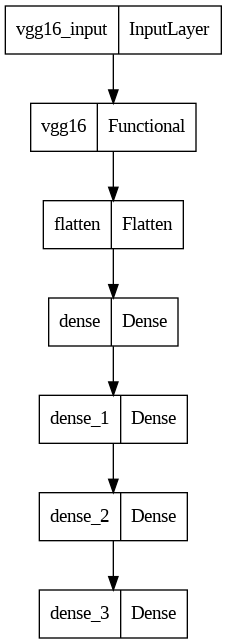

In [ ]:
from tensorflow.keras.utils import plot_model

plot_model(model)

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 20, 20, 512)       14714688  
                                                                 
 flatten (Flatten)           (None, 204800)            0         
                                                                 
 dense (Dense)               (None, 128)               26214528  
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 40,939,585
Trainable params: 26,224,897
No

Preparamos todo para poder guardar el mejor modelo en drive. Darle OK cuando te salte la ventana emergente.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
if not os.path.isdir('/content/gdrive/MyDrive/bestmodels'):
  print('creando best model para vos bebe')
  os.makedirs('/content/gdrive/MyDrive/bestmodels')
else:
  print('ya existe la carpeta, good')

ya existe la carpeta, good


Preparar callbacks de early stopping y de best model.

!!! Cambiar el nombre del modelo a algo propio

In [ ]:
es_callback = callbacks.EarlyStopping(
    monitor='val_auc',
    patience=8,
    verbose=1)

model_name = f'best_vgg_model.h5' # MODIFICAR CON LO PROPIO

mc_callback = callbacks.ModelCheckpoint(
    filepath=f'/content/gdrive/MyDrive/bestmodels/{model_name}',
    monitor='val_auc',
    mode='max',
    save_best_only=True)

Ejecutar

In [ ]:
history = model.fit(train_generator, epochs=25,
                    validation_data=valid_generator,
                    callbacks = [es_callback,mc_callback])

Epoch 1/25
22/22 [==============================] - 85s 2s/step - loss: 5.1202 - auc: 0.4241 - val_loss: 8.8075 - val_auc: 0.5000
Epoch 2/25
22/22 [==============================] - 30s 1s/step - loss: 1.8645 - auc: 0.6926 - val_loss: 1.8434 - val_auc: 0.4888
Epoch 3/25
22/22 [==============================] - 34s 2s/step - loss: 1.6822 - auc: 0.6570 - val_loss: 0.6430 - val_auc: 0.5165
Epoch 4/25
22/22 [==============================] - 40s 2s/step - loss: 0.9910 - auc: 0.6318 - val_loss: 0.7445 - val_auc: 0.6049
Epoch 5/25
22/22 [==============================] - 35s 2s/step - loss: 1.3644 - auc: 0.6173 - val_loss: 0.6808 - val_auc: 0.6233
Epoch 6/25
22/22 [==============================] - 37s 2s/step - loss: 0.9854 - auc: 0.7108 - val_loss: 0.6502 - val_auc: 0.6335
Epoch 7/25
22/22 [==============================] - 36s 2s/step - loss: 0.4500 - auc: 0.8980 - val_loss: 0.8624 - val_auc: 0.6697
Epoch 8/25
22/22 [==============================] - 36s 2s/step - loss: 1.0388 - auc: 0.77

## Resultados

Cargar best model

In [ ]:
best_model = tf.keras.models.load_model(f'/content/gdrive/MyDrive/bestmodels/{model_name}')

Vemos resultados en test con TF. Esta no es la que vamos a anotar en el excel.

In [ ]:
results = best_model.evaluate(test_generator, verbose=0)
print('Test Loss: {}'.format(results[0]))
print('Test AUC: {}'.format(results[1]))

Test Loss: 0.44142380356788635
Test AUC: 0.8985507488250732


Ploteamos

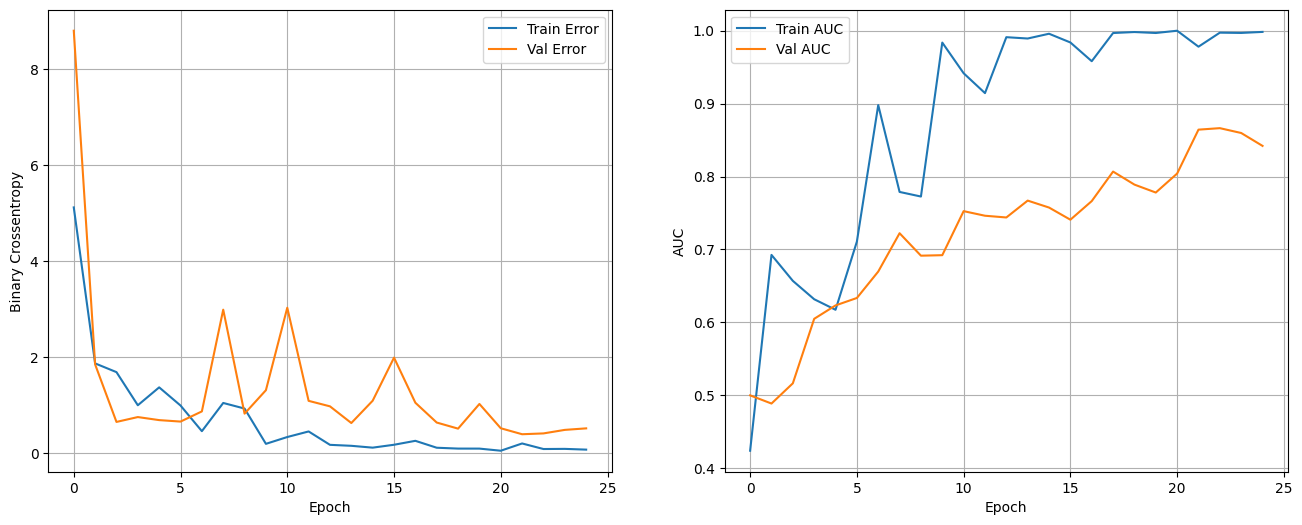

In [ ]:
def show_loss_auc_evolution(history):

    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Binary Crossentropy')
    ax1.plot(hist['epoch'], hist['loss'], label='Train Error')
    ax1.plot(hist['epoch'], hist['val_loss'], label = 'Val Error')
    ax1.grid()
    ax1.legend()

    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('AUC')
    ax2.plot(hist['epoch'], hist['auc'], label='Train AUC')
    ax2.plot(hist['epoch'], hist['val_auc'], label = 'Val AUC')
    ax2.grid()
    ax2.legend()

    plt.show()

show_loss_auc_evolution(history)

Insight de resultados

In [ ]:
true_labels = test_generator.labels

In [ ]:
predictions = best_model.predict(test_generator)
preds = np.round(predictions).flatten()

3/3 [==============================] - 3s 1s/step


Accuracy y AUC de sklearn

!! Ver que da distinta a la de TF. Es porque tienen configurados disitntos thresholds.

In [ ]:
from sklearn.metrics import accuracy_score, roc_auc_score

print(f'Accuracy en test: {accuracy_score(true_labels,preds)}')

print(f'AUC en test: {roc_auc_score(true_labels,preds)}')

Accuracy en test: 0.7808219178082192
AUC en test: 0.7878421900161031


Classification report

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

print(classification_report(true_labels,preds))

              precision    recall  f1-score   support

           0       0.67      0.81      0.73        27
           1       0.88      0.76      0.81        46

    accuracy                           0.78        73
   macro avg       0.77      0.79      0.77        73
weighted avg       0.80      0.78      0.78        73



Matriz de confusion

In [ ]:
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.grid(False)

Confusion matrix, without normalization
[[22  5]
 [11 35]]


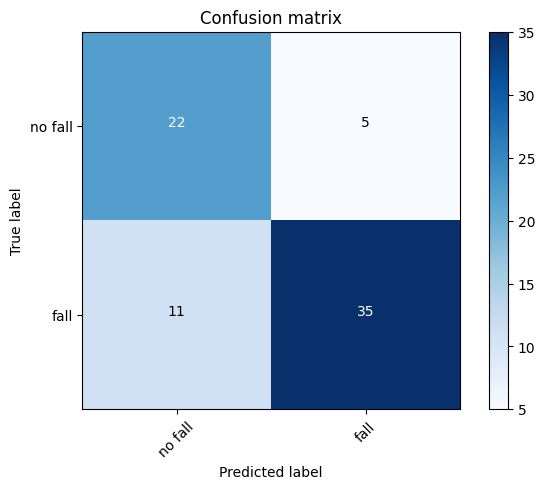

In [ ]:
class_names = list(test_generator.class_indices.keys())
plot_confusion_matrix(confusion_matrix(true_labels,preds),class_names)
plt.show()

## Ejemplos de errores

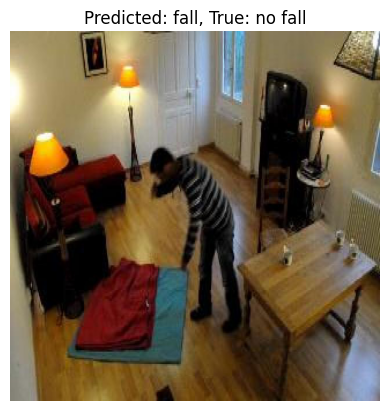

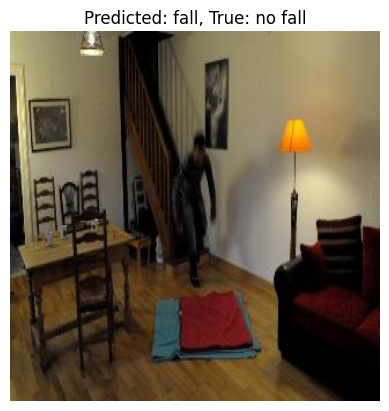

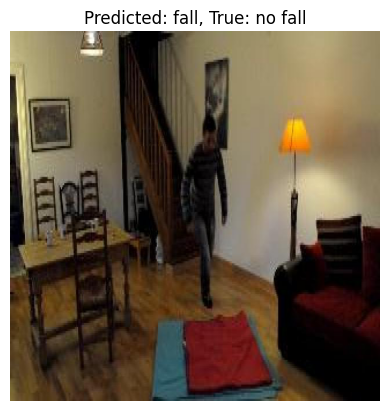

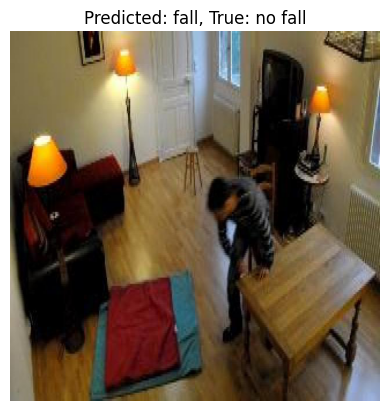

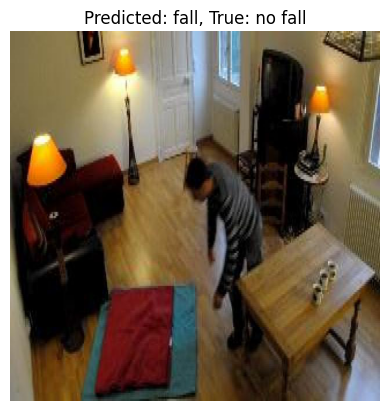

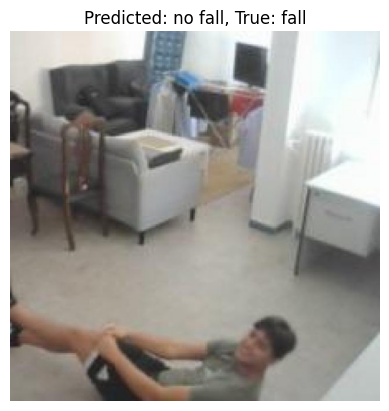

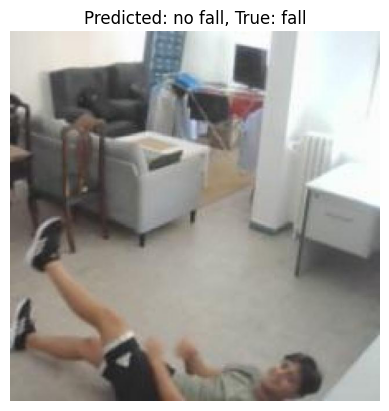

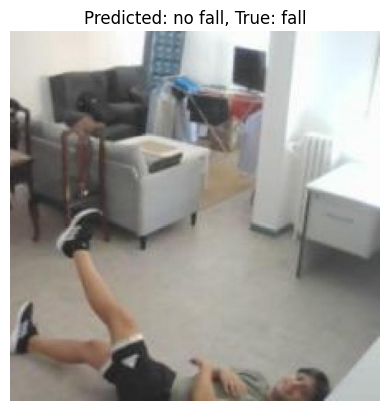

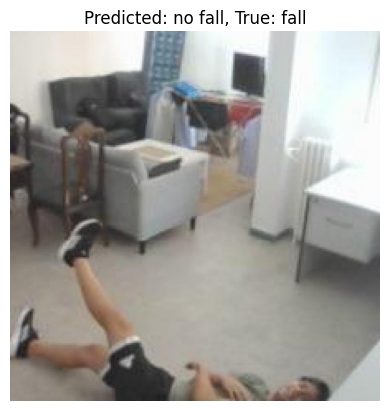

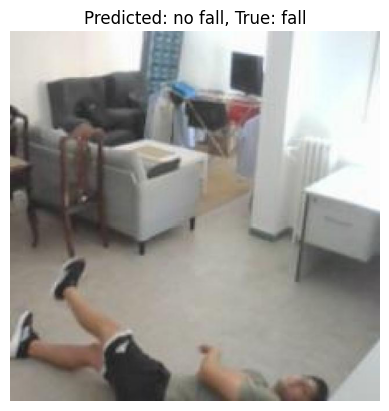

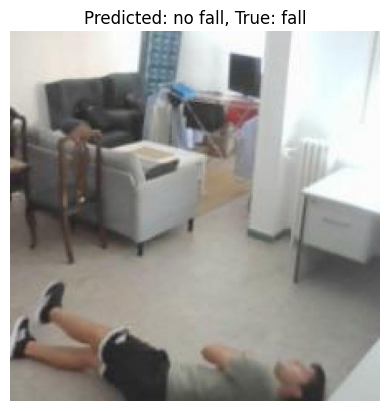

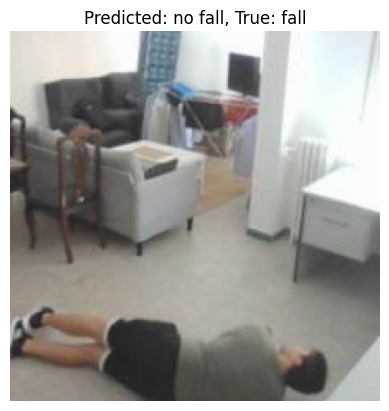

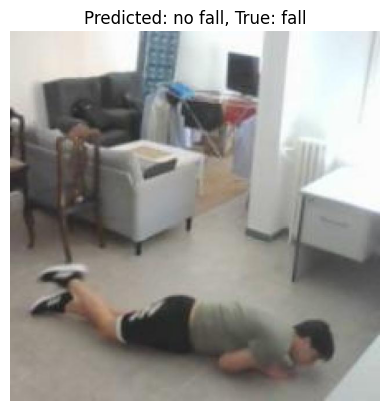

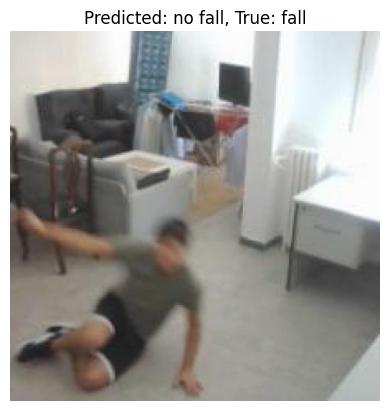

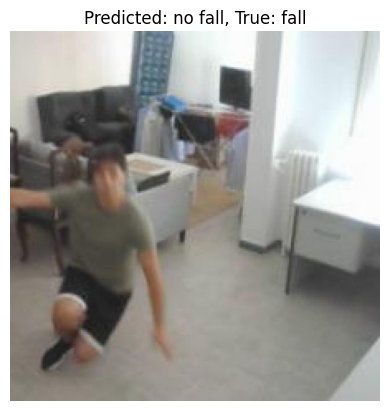

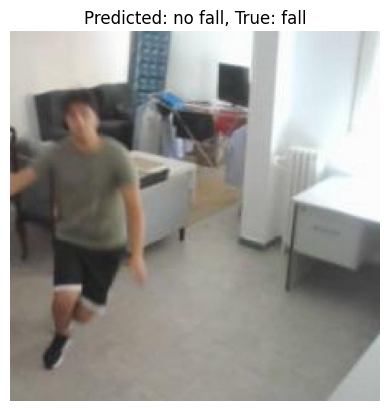

In [ ]:
# Recorre las imágenes de prueba y muestra cada una con su predicción y etiqueta real
for i in range(len(test_generator.filenames)):

    if class_names[int(preds[i])] != class_names[true_labels[i]]:

      image_path = test_dir + '/' + test_generator.filenames[i]
      image = plt.imread(image_path)

      plt.imshow(image)
      plt.title(f'Predicted: {class_names[int(preds[i])]}, True: {class_names[true_labels[i]]}')
      plt.axis('off')
      plt.show()

    else:
      pass